In [5]:
import numpy as np
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import csv, random, pdb, sys
from IPython.core.debugger import set_trace
import copy

In [6]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: None
PATH: /apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7:/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/sbin:/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/bin:/apps/software/standard/compiler/gcc/9.2.0/nodejs/12.14.1/bin:/apps/software/standard/core/gcc/9.2.0/bin:/usr/lib64/qt-3.3/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/ibutils/bin:/opt/slurm/current/bin:/opt/singularity/current/bin:/opt/rci/bin:/share/rci_apps/common/bin:/share/resources/HPCtools:/opt/mam/current/bin


In [7]:

'''
Cvacc[i] = cost of vaccination for node i
Cinf[i]: cost of infection for node i
x[i]: current strategy of node i
    x[i] = 1 ==> i is vaccinated
S(x): set of vaccinated nodes
comp(x): components formed by residual nodes
cost[i]: cost of node i

#Evaluating reduction in cost for node i
#return old cost - new cost
def reduction_in_cost(x, comp, cost, Cvacc, Cinf, i)
    if x[i] == 0, then return  cost[i] - Cvacc[i]
    if x[i] == 1
        A = {comp(j, x): j is a nbr of i }
        N = \sum_{X in A} |X|
        return  Cvacc[i] - N^2 Cinf[i]/n

#best response
def best_respose(Cvacc, Cinf)
    xinit: random strategy
    initialize comp, cost
    for t = 1.. T:
        for i in V:
            if reduction_in_cost(x, i) > 0:
                flip x[i]
                update comp

#possible efficiencies
    #uniform Cvacc, Cinf setting
        if there is a large comp X: check benefit of vaccination
        if all comp are small: check benefit of not vaccinating
'''


#each line: id1, id2
def read_graph(fname):
    G = nx.Graph()
    fp_reader = csv.reader(open(fname), delimiter = ' ')
    headers = next(fp_reader) 
    count = 0
    for line in fp_reader:
        if line[1] != line[2]: 
            G.add_edge(line[1], line[2])
        count += 1
        if count >= 1000:
            break
    return G

#create components
#x: strategy vector where x[i] = 1 means i is vaccinated
def init_comp(G, x):

    # comp_id: {node u: component_id i}; mapping of each node to it's current component id
    # comp_len: {component_id i: length(int)}; mapping of component id to its length
    # comp_d: {component_id i: list of node in ith component}
    # max_comp_id: integer; each time we create a new component id so it will be helpful.
    comp_id = {}; comp_len = {}; comp_d = {}; max_comp_id = 0
    
    H = nx.Graph()
    for u in G.nodes(): 
        H.add_node(u)
    for e in G.edges():
        u = e[0]; v = e[1]
        if x[u] == 0 and x[v] == 0: #both nodes unvacccinated
            H.add_edge(u, v)
    comp = nx.connected_components(H)
    
    for c in list(comp):
        max_comp_id += 1
        for u in c: 
            comp_id[u] = max_comp_id
        comp_len[max_comp_id] = len(list(c))
        comp_d[max_comp_id] = list(c)

    return H, comp_d, comp_id, comp_len, max_comp_id

def comp_cost(G, x, Cvacc, Cinf, p):
    cost = {}
    #calculate #unvacc nbrs for each node
    H = nx.Graph()
    for e in G.edges():
        H.add_edge(e[0], e[1])
    for i in x:
        if x[i] == 1: 
            cost[i] = Cvacc[i]
        else: 
            cost[i] = (1 + p*(H.degree(i)))/(len(x)+0.0)
    return cost


#return reduction in cost if node u flips its strategy
def reduction_in_cost(G, x, p, cost, Cvacc, Cinf, u):
    if x[u] == 0: 
        return  cost[u] - Cvacc[u]
    if x[u] == 1:
        num_unvacc_nbrs = 0
        for v in G.neighbors(u): 
            if x[v] == 0: num_unvacc_nbrs += 1
        return cost[u] - (1 + p*num_unvacc_nbrs)/(len(x)+0.0)


def check_NE(G, x, p, cost, Cvacc, Cinf):
    num_violated = 0
    for u in G.nodes():
        if reduction_in_cost(G, x, p, cost, Cvacc, Cinf, u) > 0: num_violated += 1
    return num_violated
            
#flip strategy of node u
def update_strategy(G, x, p, cost, Cvacc, Cinf, u):

    if x[u] == 0:
        x[u] = 1
        cost[u] = Cvacc[u]
        return x, cost

    else: #x[u] = 1
        x[u] = 0
        num_unvacc_nbrs = 0
        for v in G.neighbors(u): 
            if x[v] == 0: num_unvacc_nbrs += 1
        cost[u] = (1 + p*num_unvacc_nbrs)/(len(x)+0.0)
        
        return x, cost
        
def print_analysis(comp_id, comp_len): 
    component_ids = np.unique(list(comp_id.values()))  
    component_lengths = [comp_len[i] for i in component_ids] 
    avg_comp_size = round(np.mean(component_lengths),2)
    max_comp_size = np.max(component_lengths)
    #print("Average component size: ", avg_comp_size)
    #print("Max component size: ", max_comp_size) 
    return avg_comp_size, max_comp_size  

#start at strategy x and run for T steps
def best_response(G, Cvacc, Cinf, x, T, p, epsilon=0.05):
#     if len(x) == 0:
#         for u in G.nodes(): x[u] = np.random.randint(0, 2)
    
    #H, comp_d, comp_id, comp_len, comp_max_id = init_comp(G, x)
    #print('x', x)
    cost = comp_cost(G, x, Cvacc, Cinf, p)
    V = G.nodes(); itrn = 0
    for t in range(T):
        #u = random.choice(list(V)); 
        num_updated = 0
        for u in G.nodes():
#             itrn += 1
#             if (itrn % 10 == 0): print(itrn)
            if reduction_in_cost(G, x, p, cost, Cvacc, Cinf, u) > 0:
                x, cost = update_strategy(G, x, p, cost, Cvacc, Cinf, u)
                num_updated += 1

        if num_updated == 0: return x, check_NE(G, x, p, cost, Cvacc, Cinf)
    
    return x, check_NE(G, x, p, cost, Cvacc, Cinf)


def save_file(filename, data):
    with open(filename, 'w') as f:
        for row in data:
            for item in row:
                f.write("%s\t" % item)
            f.write("\n")


def save_degree_hist(comp_id, comp_len, comp_d, G, alpha):     
    component_ids = np.unique(list(comp_id.values()))  
    component_lengths = [comp_len[i] for i in component_ids] 
    index_max = np.argmax(component_lengths)
    max_comp = component_ids[index_max]
    max_comp_nodes = comp_d[max_comp]
    max_nodes_degrees = [G.degree(node) for node in max_comp_nodes]
    plt.hist(max_nodes_degrees, density=False, bins=20)  # `density=False` would make counts
    plt.ylabel('Num of nodes')
    plt.xlabel('Degree');
    plt.title("Histogram of degrees for Max Component Nodes; alpha: " + str(alpha) + "; len: " + str(len(max_comp_nodes)))
    plt.savefig("../out/fig/max_comp_nodes_alpha_" + str(alpha) + ".png")
    plt.show()

def save_graph_data(comp_id, comp_len, comp_d, G):     
    graph_data = {}
    graph_data['comp_id'] = comp_id
    graph_data['comp_len'] = comp_len
    graph_data['comp_d'] = comp_d
    graph_data['nodes'] = list(G.nodes())
    graph_data['edges'] = list(G.edges())
    graph_data['degree'] = dict(G.degree)
    return graph_data



def remove_topk_nodes(G, k):
    degree_tup = list(dict(G.degree).items())
    degree_tup = sorted(degree_tup, key=lambda x: -1*x[1])
    top_k_nodes = [x for x,d in degree_tup[:k]]
    G_res = copy.deepcopy(G)
    for node in top_k_nodes:
        G_res.remove_node(node)
    
    return G_res

def exp_infsize(G, x, p):
    num_itrn = 100
    z = 0
    for i in range(num_itrn):
        H = nx.Graph()
        for u in G.nodes(): 
            if x[u] == 0: H.add_node(u)
        for e in G.edges():
            if x[e[0]] == 0 and x[e[1]] == 0 and random.random() <= p:
                H.add_edge(e[0], e[1])
        comp = nx.connected_components(H)
        z1 = 0
        for c in list(comp):
            a = len(list(c))
            z1 += a*a
        z += z1/(len(x)+0.0)
        
    return z/(num_itrn*len(x)+0.0)



def get_topk_nodes(G, k):
    degree_tup = list(dict(G.degree).items())
    degree_tup = sorted(degree_tup, key=lambda x: -1*x[1])
    top_k_nodes = [x for x,d in degree_tup[:k]]
    return top_k_nodes

In [10]:
if __name__ == '__main__':
### run for a fixed network and fixed alpha
##########################################
    
    T = 100
    epsilon = 0.001
    alphavals = np.arange(0,50,1)
    #alphavals = sys.argv[1]

    num_times = 10



    avg_file_name = './vacc_albemarle_household_1_7_dec7_avg.txt'
    raw_file_name = './vacc_albemarle_household_1_7_dec7_raw.txt' 
    
    raw_data = []
    np.random.seed(0)

    #### read from a fixed graph
    #G = read_graph('household_undirected_albe_1.90.txt')

    n = 10000; m = 3
    G = nx.barabasi_albert_graph(n, m)
    
    p = 0.4; T = 100

    exp_inf_list = []
    exp_inf_std = []

    n_vacc_size = []

    xlist_alpha = {}

    for alpha in alphavals:
        zs = []
        vacc_size = []
        
        xlist = []
        for i in range(num_times):
            x = {}; Cvacc = {}; Cinf = {};
            for u in G.nodes():
                x[u] = np.random.randint(0, 2)
                Cinf[u] = 1; 
                Cvacc[u] = Cinf[u]*float(alpha)/n
                
            x, nviol = best_response(G, Cvacc, Cinf, x, T, p, epsilon)

            if(nviol == 0):
                z = exp_infsize(G, x, p)
                zs.append(z)

                vaccinated = len([i for i in x if x[i] == 1])
                vacc_size.append(vaccinated)

                xlist.append(x)

        n_vacc_size.append(vacc_size)
        xlist_alpha[alpha] = xlist
        
        zs = np.array(zs)
        exp_inf_list.append(zs.mean())
        exp_inf_std.append(zs.std())
    
    n_vacc_size = np.array(n_vacc_size)


In [11]:
print(exp_inf_list)
print(exp_inf_std)

[0.0, 0.0, 0.00022885428, 0.0006958182400000001, 0.13086218374, 0.25400549566, 0.37557958140000003, 0.42407511838000006, 0.48492391632, 0.5121454327999999, 0.54447920318, 0.5636708501000001, 0.5836822747199999, 0.59087683224, 0.5984613470000001, 0.6083044654800001, 0.6194928231200001, 0.6216024601399999, 0.6300455219999999, 0.63128874684, 0.6388693884399999, 0.64003664652, 0.64235834904, 0.6451218618400001, 0.64673986678, 0.65302359618, 0.6529182763400001, 0.6555265846599999, 0.6535329856, 0.6585587339200001, 0.66102489728, 0.66300840412, 0.6653355531, 0.6667241598200001, 0.6682274263999999, 0.6714557698199999, 0.67268932966, 0.6718161862399998, 0.67472923196, 0.67338426182, 0.67561834808, 0.67612109602, 0.67596861658, 0.67642359756, 0.67776951562, 0.6784739283, 0.67974890454, 0.6754258747599999, 0.67695780678, 0.6781948295800001]
[0.0, 0.0, 3.778736433465562e-06, 6.893375792053128e-05, 0.0035387602081800684, 0.010760047860495642, 0.009643921197824316, 0.006805026208350924, 0.005957578

In [12]:
z4 = [0.0, 0.0, 0.00022885428, 0.0006958182400000001, 0.13086218374, 0.25400549566, 0.37557958140000003, 0.42407511838000006, 0.48492391632, 0.5121454327999999, 0.54447920318, 0.5636708501000001, 0.5836822747199999, 0.59087683224, 0.5984613470000001, 0.6083044654800001, 0.6194928231200001, 0.6216024601399999, 0.6300455219999999, 0.63128874684, 0.6388693884399999, 0.64003664652, 0.64235834904, 0.6451218618400001, 0.64673986678, 0.65302359618, 0.6529182763400001, 0.6555265846599999, 0.6535329856, 0.6585587339200001, 0.66102489728, 0.66300840412, 0.6653355531, 0.6667241598200001, 0.6682274263999999, 0.6714557698199999, 0.67268932966, 0.6718161862399998, 0.67472923196, 0.67338426182, 0.67561834808, 0.67612109602, 0.67596861658, 0.67642359756, 0.67776951562, 0.6784739283, 0.67974890454, 0.6754258747599999, 0.67695780678, 0.6781948295800001]
z4std = [0.0, 0.0, 3.778736433465562e-06, 6.893375792053128e-05, 0.0035387602081800684, 0.010760047860495642, 0.009643921197824316, 0.006805026208350924, 0.00595757801227851, 0.008745308042417313, 0.006035548642917904, 0.004889540457249016, 0.004490308959595819, 0.004191457372551505, 0.004643362853436289, 0.006981072812935535, 0.004781059423529451, 0.004800182825833212, 0.002896428805938918, 0.0037653838247136743, 0.004213248930078148, 0.0026591756454889186, 0.0034814414530070846, 0.004760472149975786, 0.003848011986938698, 0.002868928765073179, 0.005092094090755213, 0.0034576777722919757, 0.0050773528325955, 0.0044469893036976635, 0.003935166383222567, 0.0030194595632816756, 0.003368622815351058, 0.0032426165133525022, 0.004281792359866888, 0.004426550230288736, 0.003864930320574102, 0.0029349690045672536, 0.0049663979278297575, 0.006292103069815459, 0.0033623076458092213, 0.004650643095323315, 0.004224537440615837, 0.002995337331727011, 0.004815795116163382, 0.0021894241548124117, 0.0027640004408884186, 0.00535852965861523, 0.004093918523829983, 0.003843017895050815]

In [14]:
z3 = [0.0, 0.0, 0.00019684128, 0.0008097150599999999, 0.0340025452, 0.15174547718, 0.21968203930000002, 0.25944859503999995, 0.3042469961, 0.3219457522000001, 0.34341891520000006, 0.3619603913600001, 0.36884360628, 0.37779218826000005, 0.38318930586000005, 0.39333729528000005, 0.39695960082000004, 0.40406936511999997, 0.41205912298, 0.4163992100400001, 0.42060636922, 0.42408437972, 0.42587387217999995, 0.4293669475799999, 0.4336943870200002, 0.4361896056600001, 0.43904945951999996, 0.43542735686, 0.43832030526, 0.44112527402, 0.4426759097, 0.4415082169200001, 0.44512668308, 0.445791908, 0.4512533673000001, 0.45215963853999996, 0.45224550027999993, 0.45212855463999996, 0.45316569848, 0.45182962726, 0.45593563828000006, 0.45618568053999997, 0.45642185494000004, 0.45465618616, 0.45806289898, 0.45954277194, 0.45911558353999987, 0.45614163324, 0.4579201973799999, 0.45872430705999995]
z3std = [0.0, 0.0, 2.2160810115155886e-06, 7.017431524123632e-05, 0.003990945002231731, 0.010651828216635082, 0.005442895975628325, 0.004643652191362333, 0.004715786303661443, 0.00939629394098293, 0.005136985006272785, 0.006458558253739401, 0.007054804797197565, 0.0023440369882161403, 0.005076136157278781, 0.0034728310023787417, 0.006842373615615853, 0.006704336118507733, 0.005711822989913425, 0.004303565237920484, 0.005049371205924295, 0.005878002218063215, 0.0034909626004661016, 0.0032752430204758837, 0.003879239839354221, 0.004801562447262576, 0.006397501004567837, 0.00463520971159531, 0.004619921413409236, 0.0045686725385961765, 0.0060788071553296375, 0.0029002923588965844, 0.006668898439136508, 0.0033501833398936883, 0.00477805427752503, 0.00488344390839903, 0.005216857214489497, 0.0050916594810401115, 0.005081401288036852, 0.004466181245640693, 0.005220221230799403, 0.005103735293078311, 0.0038784083146029503, 0.004037095468949506, 0.0041995879528437694, 0.004208360291714818, 0.004848841926412745, 0.0034790620930477494, 0.004447962443028613, 0.0025007041481902356]

In [15]:
n_num_vacc_list = np.array(n_vacc_size)
vacc_mean = n_num_vacc_list.mean(axis = 1)
vacc_std = n_num_vacc_list.std(axis = 1)

print(list(vacc_mean))
print(list(vacc_std))

[10000.0, 10000.0, 2171.0, 1412.0, 729.1, 520.6, 341.1, 274.3, 195.9, 162.1, 122.0, 101.3, 79.9, 72.1, 63.8, 55.0, 44.9, 43.0, 36.2, 34.8, 28.7, 27.4, 25.9, 24.0, 22.3, 19.3, 18.8, 17.8, 19.0, 16.0, 14.9, 13.5, 12.6, 11.8, 11.1, 9.8, 9.4, 9.7, 8.5, 8.9, 8.2, 8.0, 7.8, 7.7, 7.4, 7.0, 6.5, 8.0, 7.6, 7.0]
[0.0, 0.0, 18.905025786811294, 8.07465169527454, 7.422263805605403, 11.60344776348823, 12.291867230002119, 7.836453279386026, 7.244998274671983, 9.170059977993601, 5.549774770204643, 4.405678154382138, 3.9610604640676716, 4.109744517606903, 3.8418745424597094, 5.118593556827891, 4.1340053217188775, 4.049691346263317, 1.7776388834631178, 2.6758176320519302, 2.794637722496424, 1.907878402833891, 2.071231517720798, 2.449489742783178, 2.193171219946131, 2.0024984394500787, 2.9597297173897483, 2.1354156504062622, 2.5298221281347035, 2.1447610589527217, 1.9209372712298547, 1.2041594578792296, 1.2806248474865698, 1.4000000000000001, 1.9209372712298547, 1.661324772583615, 1.8, 1.0999999999999999

In [18]:
vacc4 = [10000.0, 10000.0, 2171.0, 1412.0, 729.1, 520.6, 341.1, 274.3, 195.9, 162.1, 122.0, 101.3, 79.9, 72.1, 63.8, 55.0, 44.9, 43.0, 36.2, 34.8, 28.7, 27.4, 25.9, 24.0, 22.3, 19.3, 18.8, 17.8, 19.0, 16.0, 14.9, 13.5, 12.6, 11.8, 11.1, 9.8, 9.4, 9.7, 8.5, 8.9, 8.2, 8.0, 7.8, 7.7, 7.4, 7.0, 6.5, 8.0, 7.6, 7.0]
vacc4std = [0.0, 0.0, 18.905025786811294, 8.07465169527454, 7.422263805605403, 11.60344776348823, 12.291867230002119, 7.836453279386026, 7.244998274671983, 9.170059977993601, 5.549774770204643, 4.405678154382138, 3.9610604640676716, 4.109744517606903, 3.8418745424597094, 5.118593556827891, 4.1340053217188775, 4.049691346263317, 1.7776388834631178, 2.6758176320519302, 2.794637722496424, 1.907878402833891, 2.071231517720798, 2.449489742783178, 2.193171219946131, 2.0024984394500787, 2.9597297173897483, 2.1354156504062622, 2.5298221281347035, 2.1447610589527217, 1.9209372712298547, 1.2041594578792296, 1.2806248474865698, 1.4000000000000001, 1.9209372712298547, 1.661324772583615, 1.8, 1.0999999999999999, 1.8027756377319946, 2.0223748416156684, 1.0770329614269007, 1.6733200530681511, 1.6, 1.1, 1.8, 0.8944271909999159, 0.806225774829855, 1.8439088914585775, 1.4966629547095764, 1.4832396974191326]

In [19]:
vacc3 = [10000.0, 10000.0, 1740.5, 876.5, 501.5, 289.5, 202.0, 155.3, 106.4, 90.9, 71.8, 56.2, 50.8, 44.4, 40.8, 34.2, 30.8, 27.1, 22.4, 20.0, 18.2, 16.6, 15.2, 13.8, 12.3, 11.1, 10.0, 11.4, 10.1, 9.3, 8.7, 9.1, 8.3, 7.9, 5.9, 6.0, 5.8, 5.6, 5.4, 5.8, 4.6, 4.3, 4.3, 4.6, 3.7, 3.5, 3.5, 4.3, 3.9, 3.6]
vacc3std = [0.0, 0.0, 14.520674915443841, 13.306013678032953, 7.22841614740048, 11.534730165894649, 4.9396356140913875, 3.4365680554879163, 3.32264954516723, 7.555792479945436, 4.422668877499196, 4.812483766206386, 4.3772137256478585, 2.009975124224178, 2.749545416973504, 2.0396078054371136, 3.6, 3.080584360149873, 2.4576411454889016, 2.1447610589527217, 2.039607805437114, 2.6532998322843198, 1.5362291495737217, 1.3266499161421599, 1.268857754044952, 1.445683229480096, 2.0976176963403033, 1.5620499351813308, 1.5132745950421556, 1.2688577540449522, 1.9519221295943134, 0.9433981132056604, 2.2825424421026654, 0.8306623862918076, 1.57797338380595, 1.4142135623730951, 1.32664991614216, 1.42828568570857, 1.42828568570857, 1.1661903789690602, 1.42828568570857, 1.1874342087037917, 1.004987562112089, 1.1135528725660042, 1.1874342087037917, 1.284523257866513, 1.118033988749895, 0.7810249675906654, 1.1357816691600546, 0.48989794855663565]

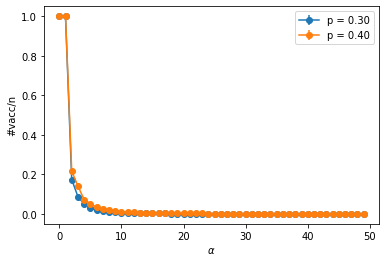

In [20]:
'1.1'
z = np.array([vacc3, vacc4])/n
zstd = np.array([vacc3std, vacc4std])/n
legend=['p = ' + str('%0.2f'%i) for i in [0.3, 0.4]]
for y,e in zip(z,zstd):
    plt.errorbar(alphavals, y, e, fmt='o-')

plt.xlabel(r'$\alpha$')
plt.ylabel('#vacc/n')
#ax.set_title('Montgomery county network')
plt.legend(legend)
plt.savefig('1_1.pdf')

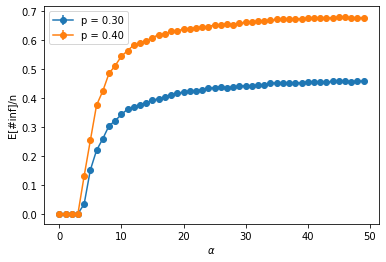

In [21]:
'1.2'
z = [z3, z4]
zstd = [z3std, z4std]
legend=['p = ' + str('%0.2f'%i) for i in [0.3, 0.4]]
for y,e in zip(z,zstd):
    plt.errorbar(alphavals, y, e, fmt='o-')

plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]/n')
#ax.set_title('Montgomery county network')
plt.legend(legend)
plt.savefig('1_2.pdf')

In [23]:
# np.random.seed(0)
# n = 1000; m = 2
# G = nx.barabasi_albert_graph(n, m)

k = vacc_mean.astype(int)
topk_list = [get_topk_nodes(G, i) for i in k]

zs = []
for knodes in topk_list:
    x = {}
    for i in G.nodes: x[i] = 0
    for i in knodes: x[i] = 1

    z = exp_infsize(G, x, p)

    zs.append(z)

In [24]:
xx = ([xlist_alpha[i][0] for i in range(0,17)])
# len(xx)topk_list[1:]
# len(topk_list[1:])
for i in xx:
    print(sum(i.values()))

len(topk_list[:17])

10000
10000
2148
1410
734
523
318
279
192
173
115
98
81
69
66
65
43


17

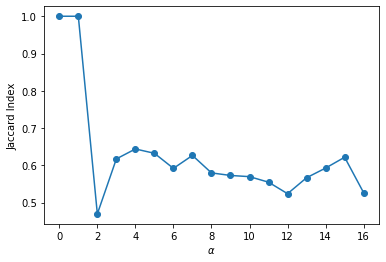

In [25]:
# set(topk_list[0])

from util import *
from strategy_vector_manipulator import *

jaccard = []
for x, knodes in zip(xx, topk_list[:17]):
    vacc = get_provax(x)
    v = intersect(set(vacc), set(knodes))
    u = union(set(vacc), set(knodes))

    jaccard.append(len(v)/len(u))

plt.plot(jaccard, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('Jaccard Index')

plt.savefig('1_4_p4.pdf')

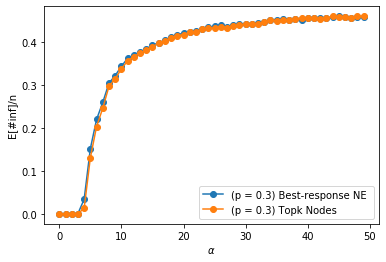

In [30]:
'1.3  p = 0.3'
exp_inf = [z3]



zs = [0.0, 0.0, 0.0001788396, 0.0005232754000000003, 0.0131777664, 0.1306637504, 0.20309854339999997, 0.24604378219999995, 0.29684684900000013, 0.3140467957999999, 0.337667122, 0.35589588859999993, 0.36608305379999995, 0.3740217119999999, 0.3811621185999999, 0.38821604999999987, 0.397890718, 0.40243844019999997, 0.40971915420000005, 0.41436836200000005, 0.417111561, 0.4221884132, 0.42404416440000003, 0.4294812454, 0.4320649349999999, 0.4324927082, 0.435319388, 0.43316677360000017, 0.4364318908, 0.43918742660000004, 0.4425691898, 0.4414084246000001, 0.44239478040000013, 0.4453535669999998, 0.45153035999999985, 0.44963483999999987, 0.4516532697999999, 0.45155272859999984, 0.45394034980000003, 0.45521231439999993, 0.45568429779999986, 0.4556074180000003, 0.45410599600000007, 0.4560027294, 0.459814193, 0.45899258560000006, 0.45888700380000014, 0.456103166, 0.459341366, 0.45972057499999996]


legend = ['(p = 0.3) Best-response NE ', '(p = 0.3) Topk Nodes']

for y in exp_inf:
    plt.plot(alphavals, y, 'o-')
    plt.plot(alphavals, zs, 'o-')


plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]/n')
#ax.set_title('Montgomery county network')
plt.legend(legend)
plt.savefig('1_3_p3.pdf')


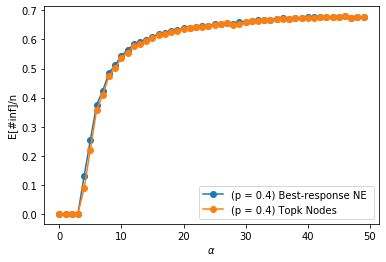

In [27]:
'1.3  p = 0.4'
exp_inf = [z4]
zs
legend = ['(p = 0.4) Best-response NE ', '(p = 0.4) Topk Nodes']

for y in exp_inf:
    plt.plot(alphavals, y, 'o-')
    plt.plot(alphavals, zs, 'o-')


plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]/n')
#ax.set_title('Montgomery county network')
plt.legend(legend)
plt.savefig('1_3_p4.pdf')

In [32]:
# p1 = [0.0, 0.0, 0.001356834, 0.0016395199999999998, 0.0017922860000000001, 0.0018332099999999996, 0.001955692, 0.002190552, 0.002336868, 0.00224686, 0.002278218, 0.0024380020000000003, 0.00243888, 0.002432844, 0.002446016, 0.0024340580000000002, 0.0024152019999999995, 0.0024434439999999995, 0.0024258120000000003, 0.00240963, 0.0024208999999999993, 0.002444848, 0.002440438, 0.002436532000000001, 0.002401036, 0.002471888, 0.0024298059999999996, 0.002452676, 0.0024213999999999998, 0.0024878699999999997, 0.0024694300000000003, 0.0024251560000000004, 0.002455742, 0.002419895999999999, 0.0024030559999999998, 0.0024264799999999995, 0.0024256200000000003, 0.0024405039999999996, 0.0024268000000000002, 0.002446722, 0.0024319320000000004, 0.0024316060000000002, 0.0024240699999999995, 0.002456836, 0.0024099399999999997, 0.00242308, 0.002425132, 0.0024358619999999996, 0.0024190439999999995, 0.002453242]

# p1std = [0.0, 0.0, 2.0913899779811447e-05, 3.620937116272522e-05, 6.0146648152660676e-05, 8.462854234831206e-05, 0.0001919547478339623, 0.00024221060558117632, 0.00018773009374098757, 0.00025216656780786774, 0.00023812349391859672, 5.785566693073376e-05, 8.18047177123666e-05, 3.544601393668972e-05, 6.203690114762359e-05, 3.670562730699464e-05, 5.271578924762506e-05, 6.882671504583042e-05, 5.280955989212564e-05, 7.294630641780262e-05, 2.7444052178932914e-05, 0.00010627293134189898, 4.384673894373436e-05, 5.6350647343220465e-05, 3.328743042050544e-05, 7.12370236323781e-05, 4.7888730240005434e-05, 6.280535824274885e-05, 9.325865879370139e-05, 5.190917086604282e-05, 4.217512276212136e-05, 4.237057639447438e-05, 5.9044651205676574e-05, 3.4728634640595864e-05, 4.933430757596541e-05, 5.839804517276251e-05, 4.6820413496679357e-05, 6.669287686102634e-05, 4.491435761535511e-05, 5.8366704515502445e-05, 6.552969903791713e-05, 5.2227654015856466e-05, 4.5141383452437426e-05, 5.999273742712543e-05, 6.783803240071171e-05, 7.494933808913864e-05, 5.1349082328704014e-05, 5.5226105747191896e-05, 7.623100461098448e-05, 7.081774322865682e-05]

# p2 = [0.0, 0.0, 0.001433094, 0.00229778, 0.003246438, 0.0054734119999999995, 0.0063207720000000005, 0.009647584, 0.011403241999999997, 0.011688994, 0.018351849999999996, 0.021807776000000004, 0.02137006, 0.024006704, 0.025558040000000004, 0.027090784, 0.026034968000000002, 0.02435717, 0.030239804000000002, 0.026383914, 0.025560657999999997, 0.027828916, 0.033203998, 0.032424176000000006, 0.033350304000000004, 0.03305050599999999, 0.033515408000000003, 0.032742716000000005, 0.03390515, 0.034068462, 0.033070576000000004, 0.033305382, 0.033790572, 0.033872104, 0.033763548, 0.033100166, 0.034020301999999995, 0.032939858, 0.03304262200000001, 0.033061815999999994, 0.033410362, 0.033844877999999995, 0.033522164, 0.033364534, 0.033005528, 0.03289569399999999, 0.033490278, 0.033634569999999996, 0.03329368000000001, 0.033927238]


# p2std = [0.0, 0.0, 2.6374609077671896e-05, 0.00010421973172101317, 0.00025291540205372976, 0.001281367805595255, 0.0016920341228521367, 0.002700414651831085, 0.0034772955248520364, 0.0029575507494147934, 0.000578771866852562, 0.006071327243302241, 0.005739868626921701, 0.007353070853790544, 0.007796270007787055, 0.008054266027619397, 0.0074322110647004665, 0.007532755729459177, 0.005894631439591794, 0.0078085787194344175, 0.00743295107009564, 0.007556190378886969, 0.0014945141264089815, 0.001583434986952103, 0.001671320201488625, 0.0011981728923006025, 0.0011210140729964084, 0.0012035204543272204, 0.0009947552466913585, 0.0009580495551045312, 0.0011726105722805033, 0.0011804075840640864, 0.0010661374964309204, 0.001728546351679351, 0.0012335714209789383, 0.0014961566556761369, 0.0007758427924496027, 0.0013663026341905373, 0.0012059619695645484, 0.0012307009247676647, 0.0014696319430782608, 0.0013464344551874761, 0.0014173241831789928, 0.0011970119226490626, 0.0014176789477790821, 0.0014026249993223435, 0.0014267298696095164, 0.0017053663941863043, 0.0009843993326287869, 0.00148784951847826]

# p3 = [0.0, 0.0, 0.001560314, 0.0031529300000000004, 0.006212870000000001, 0.014188239999999996, 0.02099983, 0.033674192000000006, 0.05152563000000001, 0.06753388400000002, 0.078577432, 0.092475028, 0.11264394800000002, 0.113822118, 0.11529896999999997, 0.12726294600000002, 0.13594339800000005, 0.133452898, 0.16783603399999997, 0.15094014, 0.16379042399999993, 0.163244178, 0.168203638, 0.16660676600000002, 0.166618448, 0.15708966, 0.16688868799999998, 0.17600677599999998, 0.163739398, 0.16394582600000002, 0.158689138, 0.16745515000000002, 0.17414242, 0.17200094400000002, 0.15892515199999996, 0.18793758, 0.18705350199999998, 0.18563104600000002, 0.186001252, 0.18696160999999997, 0.18758192199999998, 0.18637813, 0.18668103, 0.185801126, 0.18634369, 0.18785227799999996, 0.187246696, 0.185594664, 0.187286782, 0.18583261399999995]

# p3std = [0.0, 0.0, 8.379074032373757e-05, 0.00033266932184979135, 0.0007182670536924278, 0.00377560911443968, 0.004026687968514571, 0.00815096456743716, 0.021589780899694655, 0.014765562284954273, 0.03163095161906604, 0.023718059968478367, 0.026406349326481608, 0.012430052460589047, 0.013259863438329208, 0.016308841750304778, 0.012402065427969471, 0.01351448498018169, 0.018783813427804386, 0.019710145424638555, 0.019115159712991773, 0.01929892798923185, 0.020417846036144823, 0.018991543207061496, 0.019595609224707863, 0.015460081270575509, 0.019782242652688704, 0.01843714165854956, 0.01962423396598084, 0.019057320768001054, 0.017959311774600834, 0.019989681594303105, 0.01824181200141257, 0.019680909141656665, 0.016415910963116724, 0.002633434230065378, 0.002296185289412858, 0.002380954650253575, 0.002307572977016323, 0.0018187566476963962, 0.0020603341843972787, 0.0025722656752715204, 0.0014346271489763516, 0.001823023711684541, 0.002500933911293951, 0.00289286540153461, 0.0014462114632044756, 0.0019527171063069893, 0.002855339661020381, 0.002368503282531795]

# p4 = [0.0, 0.0, 0.001481984, 0.0031443239999999996, 0.009401722000000001, 0.029607764, 0.06067971, 0.10363233599999999, 0.153822308, 0.18284513800000002, 0.213303794, 0.23223928000000002, 0.26314762599999997, 0.265251792, 0.31327799800000006, 0.30961402600000004, 0.312122954, 0.30362928599999994, 0.330901828, 0.3544949, 0.37452981400000007, 0.37077028000000006, 0.37483434400000004, 0.368068752, 0.38126724599999995, 0.39660730000000005, 0.397572104, 0.401242356, 0.403184506, 0.40486870999999985, 0.402905432, 0.403221516, 0.40280686999999993, 0.403048218, 0.403434544, 0.404050158, 0.40382640599999997, 0.40243373799999993, 0.403100568, 0.40260349, 0.40438719799999995, 0.40537511400000004, 0.40118677199999997, 0.404333234, 0.4040706620000001, 0.40422561999999995, 0.40245741399999996, 0.40306282200000004, 0.404899568, 0.40370057]

# p4std = [0.0, 0.0, 3.989599458592297e-05, 0.0002759866635618465, 0.0022981952626084674, 0.007101842809703975, 0.015235575480287575, 0.016737412771029563, 0.026461700272474104, 0.029547284642130436, 0.02387129339506519, 0.034882775592830366, 0.03211406429879726, 0.024426428810719242, 0.031116369855173576, 0.02441371099051359, 0.03474121221133429, 0.01744917368692979, 0.02715774157345666, 0.032513208761727586, 0.02335676654213599, 0.013140068529133353, 0.02869337879436412, 0.0176499336920051, 0.017889052225159522, 0.01165323532454398, 0.011432640325687887, 0.001893072903441385, 0.002166512443814747, 0.0021823391684016196, 0.003374204594451257, 0.002213626394689028, 0.002810529410146822, 0.003308235442243509, 0.002752584032225708, 0.0020882475265820246, 0.0036182267996358874, 0.0014579671259791636, 0.003771599400426313, 0.003029068104130421, 0.002035889766042271, 0.003265324087536166, 0.002554600470886976, 0.0016174850493540483, 0.00337149598423554, 0.003200973861461557, 0.00405439130445051, 0.0028993829777584934, 0.003415075620143104, 0.003101474412420674]


In [28]:
# z = [z3, z4]
# zstd = [ z3std, z4std]
# legend = ['p = ' + str('%0.2f'%i) for i in [0.3, 0.4]]
# for y in p:
#     plt.plot(alphavals, y, 'o-')

# plt.xlabel(r'$\alpha$')
# plt.ylabel('E[#inf]')
# #ax.set_title('Montgomery county network')
# plt.legend(legend)
# #plt.savefig('out/montgomery_p0.0435.png')

In [22]:
max([G.degree(v) for v in G.nodes()])

103

In [ ]:
s